In [1]:
# imports and utils

import tensorflow.compat.v2 as tf
import ddsp.training
_AUTOTUNE = tf.data.experimental.AUTOTUNE
from IPython.display import Audio, display
from livelossplot import PlotLosses
import numpy as np
import random 
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time
import data
import random
import copy
import pydash
import tqdm
import soundfile
import os

# define constants
CLIP_S=4
SAMPLE_RATE=48000
N_SAMPLES=SAMPLE_RATE*CLIP_S

SEED=1
FT_FRAME_RATE=250

tf.random.set_seed(
    SEED
)
np.random.seed(SEED)
random.seed(SEED)

# define some utilis
def play(audio):
  display(Audio(audio,rate=SAMPLE_RATE))

In [2]:
USE_NSYNTH=False

if USE_NSYNTH:
    tfds.load("nsynth/gansynth_subset.f0_and_loudness",split="train", try_gcs=False,download=True) 
    trn_data_provider = data.CustomNSynthTfds(data_dir="/root/tensorflow_datasets/",split="train")
    tfds.load("nsynth/gansynth_subset.f0_and_loudness",split="valid", try_gcs=False,download=True) 
    val_data_provider = data.CustomNSynthTfds(data_dir="/root/tensorflow_datasets/",split="valid")
    def crepe_is_certain(x):
        is_playing = tf.cast(x["loudness_db"]>-100.0,dtype=tf.float32)
        average_certainty=tf.reduce_sum(x["f0_confidence"]*is_playing)/tf.reduce_sum(is_playing)
        return average_certainty
    INSTRUMENT_FAMILY="all"
    def preprocess_dataset(dataset):
        if INSTRUMENT_FAMILY!="all":
            dataset=dataset.filter(lambda x: x["instrument_family"]==INSTRUMENT_FAMILY)
        return dataset
    trn_dataset = preprocess_dataset(trn_data_provider.get_dataset())
    val_dataset = preprocess_dataset(val_data_provider.get_dataset())

else:
    INSTRUMENT_FAMILY="Trombone"
    
    trn_data_provider=data.MultiTFRecordProvider(f"datasets/AIR/tfr48k/dev/{INSTRUMENT_FAMILY}/*",sample_rate=SAMPLE_RATE)
    trn_dataset= trn_data_provider.get_dataset()
    
    val_data_provider=data.MultiTFRecordProvider(f"datasets/AIR/tfr48k/tst/{INSTRUMENT_FAMILY}/*",sample_rate=SAMPLE_RATE)
    val_dataset=val_data_provider.get_dataset(shuffle=False)

2022-02-28 15:47:56.889580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 15:47:56.907558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 15:47:56.908311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 15:47:56.909779: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
class CustomRnnFcDecoder(ddsp.training.nn.OutputSplitsLayer):
  """RNN and FC stacks for f0 and loudness.
  Allows for bidirectionality
  """

  def __init__(self,
               rnn_channels=512,
               rnn_type='gru',
               ch=512,
               layers_per_stack=3,
               input_keys=('ld_scaled', 'f0_scaled','z'),
               output_splits=(('amps', 1), ('harmonic_distribution', 40)),
               bidir=True,
               **kwargs):
    super().__init__(
        input_keys=input_keys, output_splits=output_splits, **kwargs)
    stack = lambda: ddsp.training.nn.FcStack(ch, layers_per_stack)
    
    # z should be considered as input
    self.input_stacks = [stack() for k in self.input_keys]
    
    self.rnn = ddsp.training.nn.Rnn(rnn_channels, rnn_type,bidir=bidir)
    self.out_stack = stack()

  def compute_output(self, *inputs):
    # Initial processing.
        
    inputs = [stack(x) for stack, x in zip(self.input_stacks, inputs)]

    # Run an RNN over the latents.
    x = tf.concat(inputs, axis=-1)
    x = self.rnn(x)
    x = tf.concat(inputs + [x], axis=-1)

    # Final processing.
    return self.out_stack(x)
 
class MultiInstrumentAutoencoder(ddsp.training.models.autoencoder.Autoencoder):
    def __init__(self,
               preprocessor=None,
               encoder=None,
               decoder=None,
               processor_group=None,
               losses=None,
               n_instruments=None,
               instrument_weight_metadata={},
               **kwargs):
        super().__init__(preprocessor,encoder,decoder,processor_group,losses,**kwargs)
        
        
        self.n_instruments=n_instruments
        self.instrument_weight_metadata=instrument_weight_metadata
        self.initialize_instrument_weights()
    
    def initialize_instrument_weights(self):
        self.instrument_weights={}
        for weight_name,weight_metadata in self.instrument_weight_metadata.items():
            self.instrument_weights[weight_name]=tf.Variable(weight_metadata["initializer"](self.n_instruments))
          
    def call(self, batch, train_shared):
        self.set_is_shared_trainable(train_shared)
        for weight_name,weights in self.instrument_weights.items():
            batch[weight_name]=tf.gather(weights,batch["instrument_idx"])
            if "processing" in self.instrument_weight_metadata[weight_name]:
                batch[weight_name]=self.instrument_weight_metadata[weight_name]["processing"](batch[weight_name])
        
        # this should go in a preprocessor but I'm too lazy to write a custom preprocessor
        batch["f0_confidence"]=batch["f0_confidence"][...,None]
        
        return super().call(batch,training=False)
    
    def set_is_shared_trainable(self,train_shared):
        if self.encoder is not None:
            self.encoder.trainable=train_shared
        if self.decoder is not None:
            self.decoder.trainable=train_shared
        return
    

from typing import Dict, Text

class Gain(ddsp.processors.Processor):
    def __init__(self, name: Text = 'gain'):
        super().__init__(name=name)
    
    def get_signal(self, signal: tf.Tensor,
                 gain_scaled: tf.Tensor) -> tf.Tensor:
        return gain_scaled * signal
    
    def get_controls(self,signal: tf.Tensor,
                 gain: tf.Tensor) -> tf.Tensor:
        return {"signal":signal,"gain_scaled":tf.nn.relu(gain)}

In [4]:
USE_F0_CONFIDENCE=True

# some checkpoints have 1050 instead..
# some have 200

N_INSTRUMENTS=200

N_NOISE_MAGNITUDES=192
N_HARMONICS=192

BIDIRECTIONAL=True

# 512 for single insturment, 1024 for multi
Z_SIZE=1024 if INSTRUMENT_FAMILY=="**" else 512

IR_DURATION=1
IR_SIZE=int(SAMPLE_RATE*IR_DURATION)

preprocessor=ddsp.training.preprocessing.F0LoudnessPreprocessor()

decoder = CustomRnnFcDecoder(
               rnn_channels=512,
               rnn_type='gru',
               ch=512,
               layers_per_stack=3,
               input_keys=("ld_scaled", 'f0_scaled','z',) if not USE_F0_CONFIDENCE else ("ld_scaled", 'f0_scaled','f0_confidence','z'),
               output_splits=(('amps', 1), ('harmonic_distribution', N_HARMONICS),('magnitudes', N_NOISE_MAGNITUDES)),
               bidir=BIDIRECTIONAL
               )

harmonic = ddsp.synths.Harmonic(
    n_samples=N_SAMPLES, sample_rate=SAMPLE_RATE, name='harmonic')

fn = ddsp.synths.FilteredNoise(
    n_samples=N_SAMPLES, window_size=0, initial_bias=-5.0, name='fn')

reverb = ddsp.effects.Reverb(name="reverb",reverb_length=IR_SIZE,add_dry=False, trainable=False)

harmonic_plus_fn= ddsp.processors.Add(name='harmonic+fn')
wet_gain_plus_dry_gain = ddsp.processors.Add(name='wet_gain+dry_gain')

dry_gain = Gain(name='dry_gain')
wet_gain = Gain(name='wet_gain')

dag = [
  (harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
  (fn, ['magnitudes']),
  (harmonic_plus_fn, ['harmonic/signal', 'fn/signal']),
  (reverb, ["harmonic+fn/signal","ir"]),
  (wet_gain,["reverb/signal","wet_gain"]),
  (dry_gain,["harmonic+fn/signal","dry_gain"]),
  (wet_gain_plus_dry_gain,["wet_gain/signal","dry_gain/signal"])
]

processor_group=ddsp.processors.ProcessorGroup(dag=dag)

fft_sizes = [64]
while fft_sizes[-1]<SAMPLE_RATE//4:
    fft_sizes.append(fft_sizes[-1]*2)
    
print(fft_sizes)

spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                             fft_sizes=fft_sizes,
                                              mag_weight=1.0,
                                              logmag_weight=1.0)

instrument_weight_metadata = {
    "z":
        {
        "initializer":lambda batch_size: tf.random.normal([batch_size,1,Z_SIZE]),
        "processing":lambda batched_feature: tf.tanh(tf.tile(batched_feature,[1,FT_FRAME_RATE*CLIP_S,1]))
        },
        "ir":
        {
            "initializer":lambda batch_size: tf.zeros([batch_size,IR_SIZE]),
            "processing":lambda batched_feature: tf.tanh(batched_feature)
            
        }
        ,
        "dry_gain":
            {
            "initializer":lambda batch_size : tf.math.sigmoid(tf.ones([batch_size,1])),
             "processing":lambda batched_feature: tf.nn.relu(batched_feature)
            },
      
        "wet_gain":
            {
            "initializer":lambda batch_size :  tf.math.sigmoid(tf.ones([batch_size,1])),
            "processing":lambda batched_feature: tf.nn.relu(batched_feature)
            }
}

ae = MultiInstrumentAutoencoder(
    preprocessor=preprocessor,
    decoder=decoder,
    processor_group=processor_group,
    n_instruments=N_INSTRUMENTS,
    instrument_weight_metadata=instrument_weight_metadata
)

[64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]


In [5]:
# remove some samples if number of recordings greater than model capacity
trn_dataset = trn_dataset.filter(lambda x: int(x["instrument_idx"])<N_INSTRUMENTS)

In [6]:
plotlosses = PlotLosses()

In [7]:
checkpoint_path=f"checkpoints/48k_{'bidir' if BIDIRECTIONAL else 'unidir'}_z{Z_SIZE}_conv_family_{INSTRUMENT_FAMILY}{'_f0c' if USE_F0_CONFIDENCE else ''}"

print(checkpoint_path)
try:
    print("loading checkpoint")
    ae.load_weights(checkpoint_path)
except:
    print("couldn't load checkpoint")
    pass

checkpoints/48k_bidir_z512_conv_family_Trombone_f0c
loading checkpoint


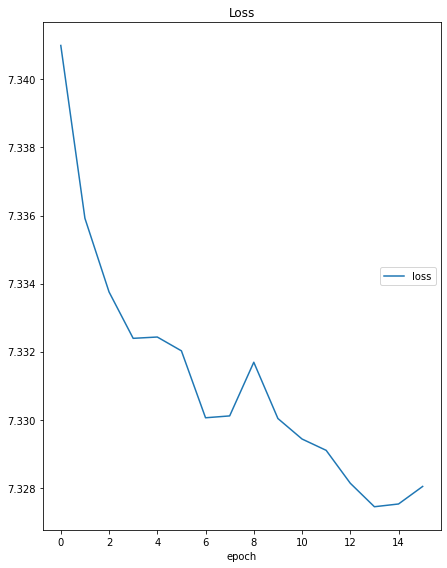

Loss
	loss             	 (min:    7.327, max:    7.341, cur:    7.328)
batch nr 0, loss: 8.218690872192383


batch nr 10, loss: 7.233660697937012
batch nr 20, loss: 6.714686870574951
batch nr 30, loss: 7.017998695373535
batch nr 40, loss: 8.439202308654785
batch nr 50, loss: 7.639801025390625
batch nr 60, loss: 7.207632064819336
batch nr 70, loss: 7.701416015625
batch nr 80, loss: 6.683904647827148
batch nr 90, loss: 6.722205638885498
batch nr 100, loss: 6.621563911437988
batch nr 110, loss: 7.316402912139893
batch nr 120, loss: 8.454852104187012
batch nr 130, loss: 7.1257195472717285
batch nr 140, loss: 6.782164573669434
batch nr 150, loss: 8.188224792480469
batch nr 160, loss: 7.08996057510376
batch nr 170, loss: 7.308720588684082
batch nr 180, loss: 7.614927768707275
batch nr 190, loss: 7.627233028411865
batch nr 200, loss: 7.526458263397217
batch nr 210, loss: 7.4693708419799805
batch nr 220, loss: 7.150809288024902
batch nr 230, loss: 6.814613342285156
batch nr 240, loss: 7.841594696044922
batch nr 250, loss: 6.8963165283203125
batch nr 260, loss: 6.875148773193359
batch nr 270, loss: 6.

In [ ]:
## training loop with adam

BATCH_SIZE=2
batched_trn_dataset=trn_dataset.shuffle(10000).batch(BATCH_SIZE,drop_remainder=True)

# 1e-4 was good for saxophone (got us to 4.7-ish in 20 hours our so)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

e=0
while True:
  batch_counter=0
  epoch_loss=0   
  for batch in batched_trn_dataset:
    with tf.GradientTape() as tape:
        output=ae(batch,train_shared=True)
        loss_value=spectral_loss(batch["audio"],output["audio_synth"])
        gradients = tape.gradient(loss_value, ae.trainable_variables)
        epoch_loss+=loss_value.numpy()
        optimizer.apply_gradients(zip(gradients, ae.trainable_variables))
        
    if batch_counter % 10==0:
        print(f"batch nr {batch_counter}, loss: {loss_value.numpy()}")

    if batch_counter ==0:    
        play(tf.reshape(output["audio"],(-1)))
        play(tf.reshape(output['audio_synth'],(-1)))
        play(tf.reshape(output['harmonic+fn']["signal"],(-1))) 
        play(tf.reshape(output['harmonic']["signal"],(-1))) 
        play(tf.reshape(output["fn"]["signal"],(-1)))
        play(tf.reshape(output["ir"],(-1)))
        
    if batch_counter>1000-1 and batch_counter % 1000==0:
        ae.save_weights(checkpoint_path)

    batch_counter+=1
    
  plotlosses.update({'loss': epoch_loss/batch_counter,})
  plotlosses.send()
  ae.save_weights(checkpoint_path)
  e+=1

In [ ]:
# define some data utilities

N_FIT_SECONDS = 16
    
TRAIN_SHARED=False

USE_FNR=True

EARLY_REFLECTION_DURATION=0.2

def join_batch(batch):
    for key in batch.keys():
        assert len(batch[key].shape)<3
        if len(batch[key].shape)==2:
            batch[key]=tf.reshape(batch[key],(1,-1))
    return batch

def window_signal(a,window_len,hop_len):
     assert(a.shape[0]==1)
     windows=[]
     start_frame=0
     while True:
        windows.append(a[:,start_frame:start_frame+window_len,...])
        start_frame+=hop_len
        if start_frame > a.shape[1]-window_len:
            break
     return tf.concat(windows,axis=0)

def window_sample(instance,win_s,hop_s):
    instance["audio"]=window_signal(instance["audio"],win_s*SAMPLE_RATE,hop_s*SAMPLE_RATE)
    for key in ["f0_hz","loudness_db","f0_confidence"]:
        instance[key]=window_signal(instance[key],win_s*FT_FRAME_RATE,hop_s*FT_FRAME_RATE)
    instance["instrument"]=tf.repeat(instance["instrument"][0],(instance["audio"].shape[0]))
    instance["instrument_idx"]=tf.repeat(instance["instrument_idx"][0],(instance["audio"].shape[0]))
    #for key,item in instance.items():
    #    assert(len(item.shape)<2 or item.shape[0]>1)
    return instance

def join_and_window(instance,win_s=4,hop_s=1):
    return window_sample(join_batch(instance),win_s,hop_s)

def rf2cf(row_form):
    return {k:[s[k] for s in row_form] for k in row_form[0].keys()}

# few shot voice cloning


def regularization(batch):
    ir = batch["ir"]
    ir = ir/tf.reduce_max(tf.abs(ir)+1e-10)
    return tf.reduce_mean((ir**2)*tf.cast(tf.linspace(0,1,ir.shape[-1])[None,:],tf.float32))*0.0

# constants
BATCH_SIZE=1

#5e-4 to 1e-5 has worked well

N_DEMO_SAMPLES=int(4*SAMPLE_RATE)

n_fit_windows=int(N_FIT_SECONDS/CLIP_S)

N_FIT_ITERATIONS= 100 if TRAIN_SHARED else int(100*(16/N_FIT_SECONDS)) 

VAL_LR=3e-5 if TRAIN_SHARED else 2e-3
SAVE = True
timestamp=0
DEMO_PATH=f"artefacts/demos/{INSTRUMENT_FAMILY}_{timestamp}_{N_FIT_SECONDS}_{'train_shared' if TRAIN_SHARED else ''}/"

DEMO_IR_DURATION=1.0
DEMO_IR_SAMPLES=int(DEMO_IR_DURATION*SAMPLE_RATE)


val_dataset=list(val_dataset)

# group by instrument id
val_dataset_by_instrument=pydash.collections.group_by(list(val_dataset),lambda x: str(x["instrument"].numpy()))
val_dataset_by_instrument = {k:v for k,v in val_dataset_by_instrument.items() if len(v)>n_fit_windows*2}

# load model
ae_test = MultiInstrumentAutoencoder(
preprocessor=preprocessor,
decoder=decoder,
processor_group=processor_group,
n_instruments=N_INSTRUMENTS,
instrument_weight_metadata=instrument_weight_metadata
)

# load model weights       

ae_test.set_is_shared_trainable(True)
ae_test.load_weights(checkpoint_path)

ae_test.instrument_weight_metadata["ir"]["initializer"]=lambda batch_size: tf.zeros([batch_size,int(DEMO_IR_DURATION*SAMPLE_RATE)])

if USE_FNR:

    er_samples=int(EARLY_REFLECTION_DURATION*SAMPLE_RATE)

    er_amp=np.ones((er_samples))
    er_amp[er_samples//2:er_samples]=np.linspace(1,0,er_samples//2)

    frame_rate=1000
    n_filter_bands=100
    n_frames=int(frame_rate*DEMO_IR_DURATION)

    ir_fn=ddsp.synths.FilteredNoise(n_samples=DEMO_IR_SAMPLES,
                                       window_size=750,
                                       scale_fn=tf.nn.relu,
                                       initial_bias=0.0001)

    def processing_fn(batched_feature):

        batch_size=batched_feature.shape[0]
        er_ir = tf.nn.tanh(batched_feature[:,:er_samples])

        er_amp=np.ones(DEMO_IR_SAMPLES)
        er_amp[er_samples//2:er_samples]=np.linspace(1,0,er_samples//2)
        er_amp[er_samples:]=0

        er_amp = er_amp[None,:]
        fn_amp= 1-er_amp

        fn_mags=tf.reshape(batched_feature[:,er_samples:],[batch_size,n_frames,n_filter_bands])
        fn_ir=ir_fn(fn_mags)

        ir=fn_ir*fn_amp+tf.pad(er_ir,[[0,0],[0,int(DEMO_IR_DURATION*SAMPLE_RATE)-er_samples]])*er_amp

        #ir = ddsp.core.fft_convolve( fn_ir,er_ir, padding='same', delay_compensation=0)
        return ir

    ae_test.instrument_weight_metadata["ir"]["processing"]=processing_fn

    ae_test.instrument_weight_metadata["ir"]["initializer"]=lambda batch_size: tf.zeros([batch_size,er_samples+n_frames*n_filter_bands])

    ae_test.instrument_weight_metadata["wet_gain"]["initializer"]=lambda batch_size: tf.ones([batch_size,1])*0.5

ae_test.initialize_instrument_weights()
ae_test.set_is_shared_trainable(True)

TMP_CHECKPOINT_PATH="artefacts/tmp_checkpoint"
ae_test.save_weights(TMP_CHECKPOINT_PATH)

for ii,instrument_set in enumerate(list(val_dataset_by_instrument.values())): 

    print(f"instrument nr {ii}")

    ae_test.set_is_shared_trainable(True)
    ae_test.load_weights(TMP_CHECKPOINT_PATH)
    ae_test.initialize_instrument_weights()

    # data
    # reshape data
    fit_data=instrument_set[:n_fit_windows]

    print(f"{len(instrument_set)-5}>={n_fit_windows}")

    assert len(instrument_set)-5>=n_fit_windows

    # Use last 4 windows (16 s) as test data
    test_data=instrument_set[-5:-1]

    def playback_and_save(x,fn):
        print(fn)
        play(x)
        if SAVE:
            os.makedirs(DEMO_PATH,exist_ok=True)
            path=DEMO_PATH+f"recording nr: {ii} "+fn+".wav"
            soundfile.write(path,x,SAMPLE_RATE)

    # convert to column form
    fit_data = rf2cf(fit_data)

    # get one batch for fitting
    fit_batch= next(iter(tf.data.Dataset.from_tensor_slices(fit_data).batch(len(list(fit_data)))))

    playback_and_save(tf.reshape(fit_data["audio"],[-1]),"training data")

    # transform data so that the clips overlap
    fit_batch=join_and_window(fit_batch,4,1)
    fit_data=tf.data.Dataset.from_tensor_slices(fit_batch)
    fit_batched=fit_data.batch(BATCH_SIZE)

    # prepare test data
    test_data = rf2cf(test_data)
    test_batched= tf.data.Dataset.from_tensor_slices(test_data).batch(BATCH_SIZE)
    

    fit_losses=[]
    tst_losses=[]

    # set up optimizer
    val_optimizer = tf.keras.optimizers.Adam(learning_rate=VAL_LR)

    for i in tqdm.tqdm(range(N_FIT_ITERATIONS)):
        fit_batched=fit_batched.shuffle(100)

        epoch_loss=0
        batch_counter=0
        test_epoch_loss=0
        test_batch_counter=0

        for fit_batch in fit_batched:
            with tf.GradientTape() as tape:

              output = ae_test(fit_batch,train_shared=TRAIN_SHARED)
              loss_value=spectral_loss(fit_batch["audio"],output["audio_synth"])+regularization(output)
              epoch_loss+=loss_value.numpy()
              batch_counter+=1
              gradients = tape.gradient(loss_value, ae_test.trainable_weights)
            val_optimizer.apply_gradients(zip(gradients, ae_test.trainable_weights))
        fit_losses.append(epoch_loss/batch_counter)


        for test_batch in test_batched:
            test_output=ae_test(test_batch,train_shared=False)
            loss_value=spectral_loss(test_batch["audio"],test_output["audio_synth"])   
            test_epoch_loss+=loss_value.numpy()
            test_batch_counter+=1
        tst_losses.append(test_epoch_loss/test_batch_counter)

        if i%50==0:

            print("target")        
            play(tf.reshape(fit_batch["audio"],(-1)))

            print("estimate")     
            play(tf.reshape(output['audio_synth'],(-1)))
            # loss plot
            plt.plot(tst_losses,label="tst")
            plt.plot(fit_losses,label="trn")
            plt.yscale("log")
            plt.legend()
            plt.show()

            ir=output['ir'][0]

            plt.plot(ir)
            plt.show()

            play(tf.reshape(ir,(-1)))

            plt.imshow(ddsp.spectral_ops.compute_mel(ir).numpy().T,aspect="auto",origin="lower")
            plt.show()

            print(f"wet gain: {output['wet_gain']['controls']['gain_scaled']}")
            print(f"dry gain: {output['dry_gain']['controls']['gain_scaled']}")

    plt.plot(tst_losses,label="tst")
    plt.plot(fit_losses,label="trn")
    plt.yscale("log")
    plt.legend()
    plt.show()

    print(">> seen data:")
    playback_and_save(tf.reshape(fit_batch["audio"],[-1]),"training target")

    playback_and_save(tf.reshape(output["audio_synth"],[-1]),"training estimate")

    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["f0_hz"]=transposed_fit_batch["f0_hz"]*0.7
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    playback_and_save(tf.reshape(transposed_output['audio_synth'],(-1)),"transposed down")

    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["f0_hz"]=transposed_fit_batch["f0_hz"]*1.3
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    playback_and_save(tf.reshape(transposed_output['audio_synth'],(-1)),"transposed up")

    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]-12
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    playback_and_save(tf.reshape(transposed_output['audio_synth'],(-1)),"loudness -12 db")

    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]-6
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    playback_and_save(tf.reshape(transposed_output['audio_synth'],(-1)),"loudness -6 db")

    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]+6
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    playback_and_save(tf.reshape(transposed_output['audio_synth'],(-1)),"loudness +6 db")

    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]+12
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    playback_and_save(tf.reshape(transposed_output['audio_synth'],(-1)),"loudness +12 db")

    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["f0_confidence"]=transposed_fit_batch["f0_confidence"]*0.9
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    playback_and_save(tf.reshape(transposed_output['audio_synth'],(-1)),"low confidence")

    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["f0_confidence"]=transposed_fit_batch["f0_confidence"]*0.5
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    playback_and_save(tf.reshape(transposed_output['audio_synth'],(-1)),"very low f0 confidence")

    transposed_fit_batch = copy.deepcopy(fit_batch)
    transposed_fit_batch["f0_confidence"]=transposed_fit_batch["f0_confidence"]*0.0
    transposed_output=ae_test(transposed_fit_batch,train_shared=False)
    playback_and_save(tf.reshape(transposed_output['audio_synth'],(-1)),"no f0 confidence")

    print(">> unseen data:")
    playback_and_save(tf.reshape(test_batch["audio"][:,:N_DEMO_SAMPLES],(-1)),"unseen target")

    test_batch_output = ae_test(test_batch,train_shared=False)
    playback_and_save(tf.reshape(test_batch_output['audio_synth'][:,:N_DEMO_SAMPLES],(-1)),"unseen estimate")


